In [1]:
# Evaluate the outputs of the movies
%load_ext autoreload
%autoreload 2
#%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

import ibl_tools
from ibl_tools.core_files import ExperimentNames, ExperimentFiles
from ibl_tools.plot import visualize_frames

# Read all experiments
experiment = ExperimentNames()
# Select subset of experiments for demo
experiment_names = ['b8875d4d-e28f-4976-859e-bf8a5dd20024_paws_small',
 'cf7972dd-e408-4759-a3e2-e404a71f13ee_paws_small',
 '735c72f4-1b43-4eb6-8754-f2e2705cdcca_paws_small',
 'b1c80c88-4e4b-4651-966c-10d3eaf9b99e_paws_small',
 'fafe6343-d1d5-4979-814b-6024e97ffb89_paws_small']

In [2]:
# Extract data of a subject
ii = 0
subject_id = experiment_names[ii]
# Read all filenames for subject
exp_files = ExperimentFiles(subject_id, ii)

/run/user/1000/gvfs/smb-share:server=locker-smb.engram.rc.zi.columbia.edu,share=paninski-locker,user=ADCU%5Cekb2154/data/ibl/dlc-networks


In [3]:
# Load training, validation and testing features
(train_, val_, test_) = exp_files.load_trace_features()
(train_data, train_slice) = train_
(val_data, val_slice) = val_
(test_data, test_slice) = test_

In [4]:

from behdata.pyhsmm.models import fit_ar_pyhsmm_models, relabel_model_z
from behdata.utils_model import create_schedule, fit_gaussian
from behdata.utils import read_pickle
from pyhsmm.util.general import rle

import os
import time
import pickle
import pandas as pd
import seaborn as sns

In [5]:
# Create jobs for file
schedule_id = 0

if schedule_id == 0:
    schedule = create_schedule(
        {
            "model": ["arhmm"],
            "emissions": ["ar"],
            "transitions": ["sticky"],
            "lags": 1,
            "affine": True,
            "alpha": 10,
            "kappa": 10**np.arange(2, 11)[::2],
            "K": 6, #range(2, 12),  # number of discrete states
            "N_iters": 2000,
            "seed": range(1),
        }
    )

Created schedule containing 5 configurations.


In [6]:
# Set directory where to read data from
log_dir = "/data/model_01_out/right_paw/subject_{:02}/".format(ii)
if not os.path.isdir(log_dir):
    print('Directory doesn''t exist')

# Set directory where to store plots
log_dir_plot = os.path.join(log_dir +'figures/')
if not os.path.isdir(log_dir_plot):
    os.makedirs(log_dir_plot)

In [7]:
print("Number of Experiments to read {}".format(len(schedule)))

# Initialize model list
ar_models = []

# Read each model
for config_id, scheduled_config in enumerate(schedule):

    print("\n--------------------------------------------\n\n")
    print("Reading experiment {} out of {}\n".format(config_id, len(schedule)))

    fname = "--".join([f"{key}-{value}" for key, value in scheduled_config.items()])

    # Check if file exists then pass
    file_out = os.path.join(log_dir, fname + ".pkl")

    if not os.path.isfile(file_out):
        print("\n Skipping file:\n{}\n already exists!\n".format(file_out))
        continue

    start = time.time()
    model = scheduled_config["model"]

    model_fit = {k: v for k, v in scheduled_config.items()}

    try:
        model_fit.update(read_pickle(file_out))

        ar_models.append(model_fit)
        print('Finished reading in {}\n'.format(time.time() - start))

    except Exception as e:
        print("\n*******\n")
        print("\nCrashed for config: \n%s\n" % str(scheduled_config))
        print(e)
        print("\n*******\n")


Number of Experiments to read 5

--------------------------------------------


Reading experiment 0 out of 5

Finished reading in 0.003927469253540039


--------------------------------------------


Reading experiment 1 out of 5

Finished reading in 0.003614664077758789


--------------------------------------------


Reading experiment 2 out of 5

Finished reading in 0.003418445587158203


--------------------------------------------


Reading experiment 3 out of 5

Finished reading in 0.0033121109008789062


--------------------------------------------


Reading experiment 4 out of 5

Finished reading in 0.002985239028930664



In [8]:
# Create dataframe
print(len(ar_models))
df = pd.DataFrame(ar_models)
print(df.keys())

model_seeds = np.unique(df['seed'].to_numpy())
model_lags = np.unique(df['lags'].to_numpy())
model_states = np.unique(df['K'].to_numpy())
model_kappas = np.unique(df['kappa'].to_numpy())

5
Index(['K', 'N_iters', 'affine', 'alpha', 'emissions', 'kappa', 'lags',
       'lls_test', 'lls_train', 'lls_val', 'model', 'seed', 'transitions'],
      dtype='object')


In [9]:
# Flag to store plots
FIG_STORE = False
# Fit a Multivariate Gaussian for reference
reference_vals = fit_gaussian(val_data)

In [10]:
# ------------------------------------------
# PLL for multiple kappas for the same state
# ------------------------------------------
model_meanplls = np.zeros((len(model_seeds), len(model_kappas)))

model_state = model_states[0]
model_lag = model_lags[0]
#%%
last_n_steps = 500
# This depends on the # PLLs available on this case just 1

for kappa_id, kappa in enumerate(model_kappas):
    # The seeds correspond to the error bars, if we have then
    for seed in model_seeds:
        # calculate mean PLL
        # Looking only at the LL once model is trained
        # as opposed to during timesteps in training
        vals = df[((df['lags'] == model_lag) & (df['K'] == model_state) & (df['kappa'] == kappa))]['lls_val']

        vals = np.asarray(vals.to_numpy()[0])
        # compare only with reference calculated after training (single step)
        if not np.any(vals):
            continue
        assert np.ndim(vals) == 1
        
        
        # divide by length of test sequence
        # vals gives us the LL for the model for all points per time step
        # ref gives us the LL for all points if fit w multivariate Gaussian

        pll_referenced = (vals[-last_n_steps:].mean() - reference_vals.sum())/len(reference_vals)
        model_meanplls[seed, kappa_id] = pll_referenced

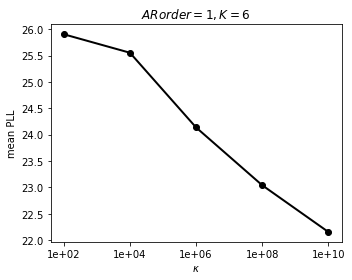

In [11]:
# x coordinates have the states
# y coordinates have the mean PLL
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot('111',facecolor='w')
# TO DO replace this st we can have confidence internals if run w multiple seeds
ax.semilogx(model_kappas, model_meanplls[0], ls='-',lw=2, marker='o',color='k')
ax.set_xscale('log')
ax.set_xticks(model_kappas)
float_formatter = lambda x: "%.e" % x
ax.set_xticklabels(list(map(float_formatter, model_kappas)))
ax.set_ylabel('mean PLL')
ax.set_title('$AR order = {},\t K = {}$'.format(model_lag, model_state))
ax.set_xlabel('$\kappa$')
#plt.xscale('log')
plt.tight_layout()
# mean PLL merge for different seeds
plot_fname = os.path.join(log_dir_plot + '/lag_{}'.format(model_lag)+ '/')
if not os.path.exists(plot_fname):
    os.makedirs(plot_fname)
plot_fname += 'PLL_kappas_state_{0:02}.pdf'.format(model_state)
if FIG_STORE:
    print('Storing in {}'.format(plot_fname))
    plt.savefig(plot_fname)
else:
    plt.show()
plt.close()

100
10000
1000000
100000000
10000000000


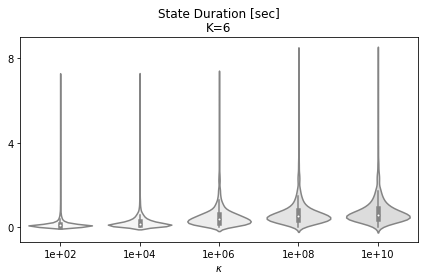

In [12]:
# ----------------------------------------------------------------------
# Look at state duration for different kappa for different state numbers
# ----------------------------------------------------------------------
# This is for a single state, so first identify your rest state
# Lags should go in different plots

train_data_index = 11
data = train_data[train_data_index]
fps = 30

model_states = np.unique(df['K'].get_values())
model_seeds = np.unique(df['seed'].get_values())
model_kappas = np.unique(df['kappa'].get_values())
state_durations = []

# This depends on the PLLs available
#ref = reference_vals[-1]
for model_lag in model_lags:
    # The seeds correspond to the error bars
    for seed in model_seeds:
        # For each state
        for k_id, k in enumerate(model_states):
            # calculate mean PLL
            # Looking only at the LL once model is trained
            # as opposed to during timesteps in training

            durations_kappas = []
            for kappa_id, kappa in enumerate(model_kappas):
                print(kappa)
                hmm = df[ ((df['lags'] ==model_lag) & (df['K'] == k) & (df['kappa']==kappa))]['model'].get_values()[0]

                # z = hmm.stateseqs[train_data_index]
                #z, perm = relabel_model_z(hmm, index=train_data_index)
                #_ , durations = rle(z)

                duration_train = []
                for train_data_index in range(len(train_data)):
                    duration_train.append(rle(hmm.stateseqs[train_data_index])[1])
                
                # durations for model for all training data in frames
                durations = np.asarray([item for sublist in duration_train for item in sublist])
                
                # convert to sec
                durations_kappas.append(durations/fps)

            frames_len = np.asarray(list(map(max,durations_kappas)))
            
            # Make plot
            float_formatter = lambda x: "%.e" %x

            fig = plt.figure(figsize=(6, 4))
            current_palette = sns.color_palette('Greys', 20)
            sns.set_palette(current_palette)
            ax = sns.violinplot(data=durations_kappas,
                                pallete=None,
                                split=True,
                                scale='width',
                                orient='v',
                                scale_hue=False)

            x_labels=list(map(float_formatter,model_kappas))
            x_labels.append(r'Labeled'+'\n'+'data')
            ax.set_xticklabels(x_labels)
            ax.set_xlabel(r'$\kappa$')
            ax.set_title('State Duration [sec]\nK={}'.format(k))
            ylabels= np.linspace(0, frames_len.max(), 3, dtype=int)
            ax.set_yticks(ylabels)
            ax.set_yticklabels(list(map(str, ylabels)))

            [t.set_color(i) for (i,t) in
             zip(['k']*(len(model_kappas))+['r'],ax.xaxis.get_ticklabels())]

            plt.tight_layout()
            # Focus on single seed
            plot_fname = os.path.join(log_dir_plot + '/lag_{0:02}'.format(model_lag)+ '/')
            if not os.path.exists(plot_fname):
                os.makedirs(plot_fname)

            plot_fname += 'State_Duration_kappa_K_{0:02d}.pdf'.format(k)

            if FIG_STORE:
                print('Storing in {}'.format(plot_fname))
                plt.savefig(plot_fname)
            else:
                plt.show()
            plt.close()


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


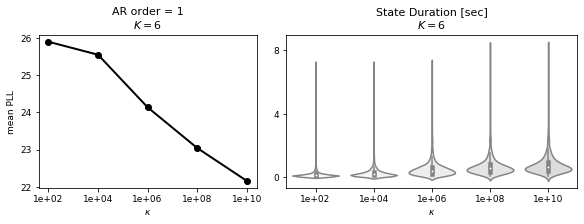

In [13]:
# Make plot
import matplotlib.font_manager

import matplotlib
matplotlib.rcParams.update({'font.sans-serif' : 'Helvetica',
                            'axes.labelsize': 9,
                            'xtick.labelsize' : 9,
                            'ytick.labelsize' : 9,
                            'axes.titlesize' : 11})

float_formatter = lambda x: "%.e" %x

widths = [0.75, 1]
gs_kw = dict(width_ratios=widths,wspace=0.01)
fig, axarr = plt.subplots(1, 2, figsize=(8, 3),constrained_layout=True, gridspec_kw=gs_kw)
current_palette = sns.color_palette('Greys', 20)
sns.set_palette(current_palette)

ax = axarr[1]
sns.violinplot(data=durations_kappas,
                    pallete=None,
                    split=True,
                    ax=ax,
                    scale='width',
                    orient='v',
                    scale_hue=False)

x_labels=list(map(float_formatter,model_kappas))
x_labels.append(r'Labeled'+'\n'+'data')
ax.set_xticklabels(x_labels)
ax.set_xlabel(r'$\kappa$')
ax.set_title('State Duration [sec]\n$K={}$'.format(k))
ylabels= np.linspace(0, frames_len.max(), 3, dtype=int)
ax.set_yticks(ylabels)
ax.set_yticklabels(list(map(str, ylabels)))

[t.set_color(i) for (i,t) in
 zip(['k']*(len(model_kappas))+['r'],ax.xaxis.get_ticklabels())]


ax = axarr[0]
ax.semilogx(model_kappas, model_meanplls[0], ls='-',lw=2, marker='o',color='k')
ax.set_xscale('log')
ax.set_xticks(model_kappas)
float_formatter = lambda x: "%.e" % x
ax.set_xticklabels(list(map(float_formatter, model_kappas)))
ax.set_ylabel('mean PLL')
ax.set_title('AR order = {}\n$K = {}$'.format(model_lag, model_state))
ax.set_xlabel('$\kappa$')

plt.tight_layout()
# Focus on single seed
plot_fname = os.path.join(log_dir_plot + '/lag_{0:02}'.format(model_lag)+ '/')
if not os.path.exists(plot_fname):
    os.makedirs(plot_fname)

plot_fname += 'State_Duration_kappa_K_{0:02d}.pdf'.format(k)

plt.savefig('kappa_k6_pll_duration.pdf')
if FIG_STORE:
    print('Storing in {}'.format(plot_fname))
    plt.savefig(plot_fname)
else:
    plt.show()
plt.close()